In [1]:
import numpy as np
import pandas as pd
pd.set_option('max_column', 999)
import regex as re
import requests
from requests.auth import HTTPBasicAuth, HTTPProxyAuth
from bs4 import BeautifulSoup
import mechanize
import zipfile
import time
import os
from urllib.error import HTTPError
from tqdm import tqdm
from itertools import cycle
from datetime import datetime
from dateutil.relativedelta import relativedelta
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_roc_curve, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
from time import time
files_dir = 'Houses/'

In [2]:
mkd_df = pd.read_csv(files_dir + 'mkd_df.csv')

/Users/a18922390/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (2,7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
mkd_df.sample(5)

,id,region_id,area_id,city_id,street_id,shortname_region,formalname_region,shortname_area,formalname_area,shortname_city,formalname_city,shortname_street,formalname_street,house_number,building,block,letter,address,houseguid,management_organization_id,built_year,exploitation_start_year,project_type,house_type,is_alarm,method_of_forming_overhaul_fund,floor_count_max,floor_count_min,entrance_count,elevators_count,energy_efficiency,quarters_count,living_quarters_count,unliving_quarters_count,area_total,area_residential,area_non_residential,area_common_property,area_land,parking_square,playground,sportsground,other_beautification,foundation_type,floor_type,wall_material,basement_area,chute_type,chute_count,electrical_type,electrical_entries_count,heating_type,hot_water_type,cold_water_type,sewerage_type,sewerage_cesspools_volume,gas_type,ventilation_type,firefighting_type,drainage_type,file
68777,6503004,de2cbfdf-9662-44a4-a4a4-8ad237ae4a3e,NaN,0648e41c-a09b-4eac-91cd-8cf61b9ccb7b,96fbf0ee-1a44-4682-b2a2-8409384fd559,Респ,Марий Эл,NaN,NaN,г,Йошкар-Ола,ул,Рябинина,27,NaN,NaN,NaN,"Респ. Марий Эл, г. Йошкар-Ола, ул. Рябинина, д...",14b31499-601f-4aad-8daf-6c4161779162,7567913.0,1957.0,1957.0,-,Многоквартирный дом,Нет,На счете регионального оператора,3.0,3.0,2.0,0.0,Не присвоен,18,NaN,NaN,1011.0,827.6,108.6,74.8,NaN,NaN,499,498,NaN,Не заполнено,Деревянные,Кирпич,NaN,Отсутствует,NaN,Центральное,NaN,Центральное,Квартирное (квартирный котел),Центральное,Центральное,NaN,Центральное,Не заполнено,Не заполнено,Не заполнено,export-reestrmkd-12-20211001.csv
575121,9392228,e5a84b81-8ea1-49e3-b3c4-0528651be129,a1bf6ac2-6525-4f4d-a8ab-98b21181a83b,b9e66b8f-b027-4e77-8466-55ba3be0b42b,17f0f5c9-c3dc-4737-ac1d-c1d35f47f84b,обл,Новгородская,р-н,Окуловский,г,Окуловка,ул,Новгородская,44б,NaN,NaN,NaN,"обл. Новгородская, р-н. Окуловский, г. Окуловк...",8c204684-40d7-4684-9dc1-bc1553f8eddc,NaN,NaN,NaN,NaN,Не заполнено,Нет,Не заполнено,NaN,NaN,NaN,NaN,Не заполнено,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,498,498,NaN,Не заполнено,Не заполнено,Не заполнено,NaN,Не заполнено,NaN,Не заполнено,NaN,Не заполнено,Не заполнено,Не заполнено,Не заполнено,NaN,Не заполнено,Не заполнено,Не заполнено,Не заполнено,export-reestrmkd-53-20211001.csv
680764,7685590,963073ee-4dfc-48bd-9a70-d2dfc6bd1f31,NaN,86e5bae4-ef58-4031-b34f-5e9ff914cd55,c5eb066b-beed-4b66-90c1-bf9aa14e7171,обл,Рязанская,NaN,NaN,г,Рязань,городок,Октябрьский,32,NaN,NaN,NaN,"обл. Рязанская, г. Рязань, городок. Октябрьски...",638661d8-909c-43da-bfcb-854bb45781b8,8827611.0,1981.0,1981.0,кирпичный,Многоквартирный дом,Нет,На специальном счете у регионального оператора,9.0,9.0,2.0,2.0,Не присвоен,70,69.0,1.0,3613.5,2264.1,777.7,226.0,0.0,"0,00",500,500,NaN,Свайный,Железобетонные,Кирпич,761.7,Отсутствует,0.0,Центральное,1.0,Центральное,Закрытая с приготовлением горячей воды на ЦТП,Центральное,Центральное,"0,00",Центральное,Приточная вентиляция,Отсутствует,Внутренние водостоки,export-reestrmkd-62-20211001.csv
879479,7670473,b6ba5716-eb48-401b-8443-b197c9578734,NaN,2d9abaa6-85a6-4f1f-a1bd-14b76ec17d9c,5d690c84-e588-4df6-88fe-39a12df893b1,край,Забайкальский,NaN,NaN,г,Чита,ул,Железобетонная,20,NaN,NaN,NaN,"край. Забайкальский, г. Чита, ул. Железобетонн...",e51c45cc-f9e3-41f5-8e66-de54e3e15b48,8924128.0,1993.0,1993.0,панельный,Многоквартирный дом,Нет,На счете регионального оператора,5.0,5.0,2.0,0.0,Не присвоен,40,40.0,0.0,3199.3,2447.0,0.0,752.0,910.6,NaN,499,500,NaN,Ленточный,Железобетонные,Панельные,514.9,Отсутствует,0.0,Центральное,1.0,Центральное,Закрытая с приготовлением горячей воды на ЦТП,Центральное,Центральное,"0,00",Отсутствует,Вытяжная вентиляция,Отсутствует,Внутренние водостоки,export-reestrmkd-75-20211001.csv
748119,8943331,92b30014-4d52-4e2e-892d-928142b924bf,NaN,2763c110-cb8b-416a-9dac-ad28a55b4402,b514d2f7-1bb5-40b3-bf63-61e8e61df02d,обл,Свердловская,NaN,NaN,г,Екатеринбург,ул,Заводская,15,NaN,5,NaN,"обл. Свердловская, г. Екатеринбург, ул. Заводс...",c1785d89-f96d-392d-9302-5a36bfc4ac70,8922014.0,1952.0,1952.0,

In [4]:
uo_df = pd.concat([pd.read_csv(files_dir + 'export-reestruo-00-20211001.csv', sep = ';')[['id','inn']],
                  pd.read_csv(files_dir + 'inn_id_link.csv')[['id','inn']]])\
.drop_duplicates().reset_index(drop=True)

In [5]:
uo_df.sample(5)

,id,inn
19293,8685089,4706033929
11387,7700728,7820313564
50653,8194789,4634009850
29839,7343769,105064259
31405,8905967,1001018813


In [6]:
rusprofile_uo_df = pd.read_csv(files_dir + 'rusprofile_uo_df.csv')

/Users/a18922390/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [7]:
def coop_flg(s):
    x = str(s).upper()
    return int(('ЖИЛИЩ' in x) & ('КООП' in x) | ('ЖСК' in x) 
               | ('ТОВАР' in x) & ('СОБСТВ' in x) | ('ТСЖ' in x) | ('ТСН' in x))

In [8]:
def rusdate(s):
    try:
        t = s.split()
        rep = {'января':'01','февраля':'02','марта':'03','апреля':'04','мая':'05','июня':'06',
              'июля':'07','августа':'08','сентября':'09','октября':'10','ноября':'11','декабря':'12'}
        x = t[0] + '.' + rep[t[1]] + '.' +t[2]
        return datetime.strptime(x,'%d.%m.%Y')
    except:
        return datetime(1990, 1, 1, 0, 0)

In [9]:
rusprofile_uo_df['regdate'] = rusprofile_uo_df['date_reg'].apply(rusdate)
rusprofile_uo_df['coop_flg'] = rusprofile_uo_df['company_name'].apply(coop_flg)

In [10]:
rusprofile_uo_df.sample(5)

,rusprofile_id,company_name,inn,ogrn,date_reg,address,url,id,regdate,coop_flg
179785,5612968,"ООО ""УК ""Комфорт""",5032242957,1115032007903,23 сентября 2011 г.,"143026, Московская область, Одинцовский район,...",https://www.rusprofile.ru/codes/683200/687,NaN,2011-09-23,0
48298,2544523,ЖСК - 11,6154031458,1026102595254,13 февраля 1964 г.,"347927, Ростовская область, город Таганрог, Тр...",NaN,7696587.0,1964-02-13,1
63954,1337263,"ТСЖ ""Заря""",4106006338,1094141000623,24 марта 2009 г.,"684300, Камчатский край, Мильковский район, се...",NaN,NaN,2009-03-24,1
48275,5443012,"ООО ""УК ""Лагуна""",1655201292,1101690056753,11 октября 2010 г.,"420097, Республика Татарстан, город Казань, ул...",NaN,7404711.0,2010-10-11,0
175584,1495308,"ООО ""Жилкомфондсервис""",5037061792,1055008513724,8 августа 2005 г.,"141100, Московская область, город Щелково, Сов...",https://www.rusprofile.ru/codes/683200/645,NaN,2005-08-08,0


In [11]:
uo_df = uo_df.merge(rusprofile_uo_df[['inn','regdate','coop_flg','company_name']], how = 'left', on = 'inn')

In [12]:
uo_df.sample(5)

,id,inn,regdate,coop_flg,company_name
23999,8094327,5307007742,2011-05-24,1.0,"ТСЖ ""Престиж"""
23466,8922927,5260278085,2010-05-14,1.0,"ТСЖ ""София"""
20778,8931847,5050121151,NaT,NaN,NaN
50777,8938157,5042046574,1970-03-03,1.0,"ЖСК "" Юбилейный"""
57200,7831199,3328449314,2007-03-02,0.0,"ООО ""Управдом"""


In [13]:
uo_hist_df = pd.concat([pd.read_csv(files_dir + 'uo_hist_df.csv'), pd.read_csv(files_dir + 'uo_tab_extra_0_177863.csv')])

In [14]:
def to_date(s):
    try:
        s_date = datetime.strptime(s, '%d.%m.%Y')
        if s_date.year in (1,1900):
            return np.datetime64('NaT')
        if s_date.year < 100:
            s_date = s_date.replace(year = s_date.year + 2000)
        if s_date.year // 100 == 2:
            s_date = s_date.replace(year = s_date.year % 100 + 2000)
        if s_date.year < 1900:
            s_date = s_date.replace(year = s_date.year + 1000)
        if s_date.year >= 3000:
            s_date = s_date.replace(year = s_date.year - 1000)
        if s_date.year >= 2021:
            return np.datetime64('NaT')
        return s_date
    except:
        return np.datetime64('NaT')

In [15]:
uo_hist_df['date_begin_corr'] = uo_hist_df['date_begin'].apply(lambda s: to_date(s))
uo_hist_df['date_end_corr'] = uo_hist_df['date_end'].apply(lambda s: to_date(s))

## Данные относительно полные с 2014 по 2018

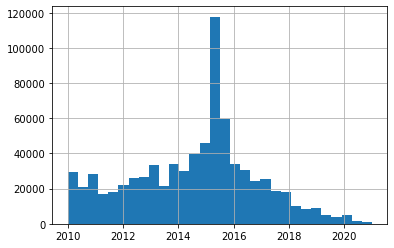

In [16]:
uo_hist_df[uo_hist_df['date_begin_corr'] >= datetime(2010, 1, 1, 0, 0)]['date_begin_corr'].hist(bins = 30);

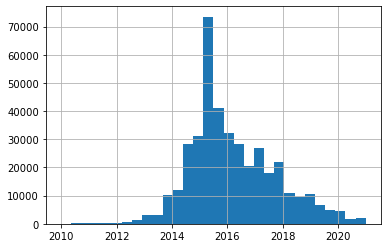

In [17]:
uo_hist_df[uo_hist_df['date_end_corr'] >= datetime(2010, 1, 1, 0, 0)]['date_end_corr'].hist(bins = 30);

## Формирование выборки и построение модели

In [18]:
def convert_dt(x):
    try:
        return datetime(int(max(int(x),1900)), 1, 1, 0, 0)
    except:
        return datetime(1965, 1, 1, 0, 0)

In [19]:
def diff_month(d1, d2):
    return (d1.year - d2.year) * 12 + d1.month - d2.month

In [126]:
mkd_num_feats = ['built_year','floor_count_max','living_quarters_count',
             'area_total','area_residential','area_land']
mkd_cat_feats = ['project_type','formalname_region','foundation_type','floor_type','wall_material',
             'hot_water_type','cold_water_type','sewerage_type','gas_type','ventilation_type']
mkd_feats = num_feats + cat_feats

In [127]:
def get_basis(dt, h = 6):
    # Базис и таргет
    beg = uo_hist_df[(uo_hist_df['date_begin_corr'] <= dt) 
                     & (uo_hist_df['date_end_corr'].fillna(datetime(2100, 1, 1, 0, 0)) > dt)]
    dt_end = dt + relativedelta(months = h)
    end = uo_hist_df[(uo_hist_df['date_begin_corr'] <= dt_end) 
                     & (uo_hist_df['date_end_corr'].fillna(datetime(2100, 1, 1, 0, 0)) > dt_end)][['uo_id','house_id']]
    end.columns = ['new_uo_id','new_house_id']
    beg = beg.merge(end, how = 'left', left_on = ['uo_id','house_id'], right_on = ['new_uo_id','new_house_id'])
    beg['response'] = beg['new_house_id'].apply(lambda x: int(x != x))
    beg['report_dt'] = dt
    beg['management_days'] = beg['report_dt'] - beg['date_begin_corr']
    
    # Информация по дому
    beg = beg.merge(mkd_df[['id'] + mkd_feats], 
                    left_on = 'house_id', right_on = 'id')
    beg['built_year_dt'] = beg['built_year'].apply(convert_dt)
    beg['house_age_days'] = beg['report_dt'] - beg['built_year_dt']
    
    # Статистика по портфелю УК
    uo_stat = uo_hist_df[['uo_id','date_begin_corr','date_end_corr']]
    uo_stat['date_end_corr'].fillna(datetime(2100, 1, 1, 0, 0), inplace = True)
    uo_stat['uo_active_houses'] = 0
    uo_stat.loc[(uo_stat['date_begin_corr'] <= dt) & (uo_stat['date_end_corr'] > dt), 'uo_active_houses'] = 1
    dt_6 = dt + relativedelta(months = -6)
    dt_12 = dt + relativedelta(months = -12)
    uo_stat['uo_lost_houses_6'] = 0
    uo_stat.loc[(uo_stat['date_end_corr'] >= dt_6) & (uo_stat['date_end_corr'] < dt), 'uo_lost_houses_6'] = 1   
    uo_stat['uo_lost_houses_12'] = 0
    uo_stat.loc[(uo_stat['date_end_corr'] >= dt_12) & (uo_stat['date_end_corr'] < dt), 'uo_lost_houses_12'] = 1
    uo_stat['uo_new_houses_6'] = 0
    uo_stat.loc[(uo_stat['date_begin_corr'] >= dt_6) & (uo_stat['date_begin_corr'] < dt), 'uo_new_houses_6'] = 1   
    uo_stat['uo_new_houses_12'] = 0
    uo_stat.loc[(uo_stat['date_begin_corr'] >= dt_12) & (uo_stat['date_begin_corr'] < dt), 'uo_new_houses_12'] = 1
    uo_stat = uo_stat.groupby('uo_id').agg({'uo_active_houses':'sum', 
                                            'uo_lost_houses_6':'sum', 'uo_lost_houses_12':'sum',
                                            'uo_new_houses_6':'sum', 'uo_new_houses_12':'sum'})
    beg = beg.merge(uo_stat, how = 'left', left_on = 'uo_id', right_index = True)
    
    # Базовая информация по УК
    beg = beg.merge(uo_df[['id','coop_flg','regdate']], how = 'left', left_on = 'uo_id', right_on = 'id')
    beg['regdate'].fillna(datetime(1990, 1, 1, 0, 0),inplace=True)
    beg['uo_age_months'] = beg['report_dt'].apply(lambda x: 12*x.year + x.month) 
    - beg['regdate'].apply(lambda x: 12*x.year + x.month)

    for col in mkd_cat_feats:
        beg[col] = beg[col].apply(str)
    return beg

In [153]:
h = 12
r_df = []
for i in tqdm(range(3)):
    r_df.append(get_basis(datetime(2015, 1, 1, 0, 0) + relativedelta(years = i), h))
basis = pd.concat(r_df)
basis.groupby('report_dt')['response'].agg(['count','sum','mean'])

  0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-127-e4a1b29758ea>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uo_stat['uo_active_houses'] = 0
<ipython-input-127-e4a1b29758ea>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uo_stat['uo_lost_houses_6'] = 0
<ipython-input-127-e4a1b29758ea>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

,count,sum,mean
report_dt,,,
2015-01-01,596166,101160,0.169684
2016-01-01,681812,60957,0.089404
2017-01-01,690620,51894,0.075141


In [205]:
# Исключим дома под управлением организаций с портфелем свыше x домов во избежание переобучения по данной фиче 
t = basis.groupby(pd.cut(basis['uo_active_houses'],np.arange(0,10000,50)))\
.agg({'response':['count','sum','mean'],'uo_id':'nunique'})
t[t[('response','count')]>0]

response                    uo_id
                    count    sum      mean nunique
uo_active_houses                                  
(0, 50]            578013  54733  0.094692   43409
(50, 100]          342892  37750  0.110093    2424
(100, 150]         208577  22766  0.109149     895
(150, 200]         151048  15671  0.103748     466
(200, 250]          96270  12814  0.133105     257
(250, 300]          82078  10683  0.130157     173
(300, 350]          79086   7453  0.094239     135
(350, 400]          60076   6083  0.101255      98
(400, 450]          54287   6576  0.121134      79
(450, 500]          31244   2200  0.070414      38
(500, 550]          33501   2800  0.083580      40
(550, 600]          49496   4563  0.092189      45
(600, 650]          17709   1117  0.063075      18
(650, 700]          23195   2502  0.107868      23
(700, 750]          14081   1158  0.082238      13
(750, 800]          15793   1815  0.114924      11
(800, 850]          17082   1391  0.081431      13
(850, 900]           9582   2407  0.251200       8
(900, 950]           8098    643  0.079402       6
(950, 1000]          4807     35  0.007281       3
(1000, 1050]        13564   1238  0.091271       7
(1050, 1100]         3922   1498  0.381948       3
(1150, 1200]         4706    166  0.035274       2
(1200, 1250]         2393     22  0.009193       1
(1250, 1300]         4976    102  0.020498       2
(1300, 1350]         6155   1035  0.168156       3
(1350, 1400]         8167    842  0.103098       4
(1400, 1450]         1394     25  0.017934       1
(1500, 1550]         1429    144  0.100770       1
(1650, 1700]         6568     53  0.008069       2
(1700, 1750]         3292    115  0.034933       1
(1800, 1850]         3637   1830  0.503162       2
(3450, 3500]         3445    143  0.041509       1
(3650, 3700]         3677    237  0.064455       1
(3800, 3850]         3788    114  0.030095       1
(6450, 6500]         6477   3860  0.595955       1
(7050, 7100]        14093   7427  0.526999       2

In [206]:
# Разделим на train и valid таким образом, чтобы портфели управляющих организацией не распадались во избежание ликов
train_uo, valid_uo = train_test_split(
    pd.DataFrame(basis[basis['uo_active_houses'] < 350]['uo_id'].unique(), columns = ['uo_id']), 
    test_size = 0.3)
train = basis.merge(train_uo, on = 'uo_id')
valid = basis.merge(valid_uo, on = 'uo_id')
print(train.shape, valid.shape)

(1135770, 41) (493794, 41)


In [207]:
train['response'].mean(), valid['response'].mean()

(0.11207022548579378, 0.12952162237694262)

In [208]:
#train, valid = train_test_split(basis[basis['uo_active_houses'] < 1500], test_size = 0.3)

In [247]:
features = ['management_days','house_age_days','uo_active_houses','uo_lost_houses_6','uo_lost_houses_12',
           'uo_new_houses_6','uo_new_houses_12','coop_flg','uo_age_months'] \
+ [x for x in mkd_feats if x not in ['built_year','project_type']]
cat_feats = [x for x in mkd_cat_feats if x not in ['built_year','project_type']]

In [248]:
# Используем деревья малой глубины для сокращения переобучения
cur_time = time()
model_cb = CatBoostClassifier(iterations = 200, verbose = False, depth = 2, cat_features = cat_feats,
                              min_child_samples = 10000, od_pval = 0.01)
model_cb.fit(train[features], train['response'], 
          eval_set = (valid[features], valid['response']),
          use_best_model = True)
print('Time elapsed:', time() - cur_time)
print('Best iteration:', model_cb.best_iteration_)

Time elapsed: 52.91070795059204
Best iteration: 38


In [249]:
#?CatBoostClassifier

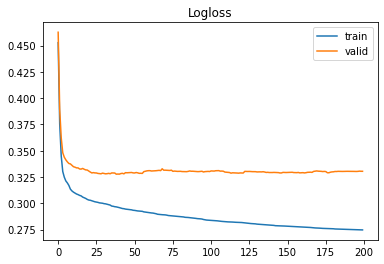

In [250]:
ax = plt.axes()
plt.plot(model_cb.evals_result_['learn']['Logloss'], label = 'train')
plt.plot(model_cb.evals_result_['validation']['Logloss'], label = 'valid')
plt.title('Logloss')
ax.legend();

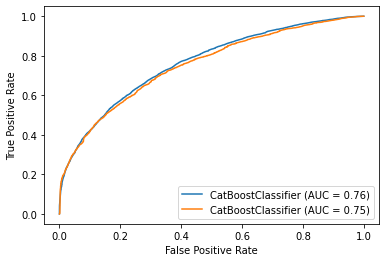

In [251]:
plot_roc_curve(model_cb, train[features], train['response'])
plot_roc_curve(model_cb, valid[features], valid['response'], ax = plt.gca());

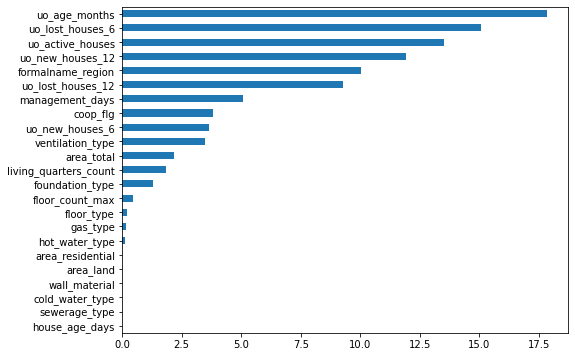

In [252]:
# Основной вклад в прогноз дает статистика по управляющей организации
pd.Series(model_cb.get_feature_importance(), index = features).sort_values().plot(kind = 'barh', figsize = (8, 6));